In [1]:
#import libraries
import numpy as np

##Costume Library to manipluate data and add indicators
from Libraries.Utils import DataHandler
from Libraries.KerasCustom import *
from IPython.display import Markdown, display

##Artificial Intelligence Library
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session
import tensorflow as tf
import gc

physical_devices = tf.config.experimental.list_physical_devices('GPU')
for i in range(len(physical_devices)):
    tf.config.experimental.set_memory_growth(physical_devices[i], True)

In [2]:
def printmd(string):
    display(Markdown(string))

In [3]:
def countUnique(a, oneHot = True):
    retStr = ""
    unique, counts = np.unique(a, return_counts=True, axis=0)
    for i in range(len(unique)):
        if oneHot:
            retStr += str(np.argmax(unique[i])) +": "+str(counts[i])+ ", "
        else:
            retStr += str(unique[i]) +": "+str(counts[i])+ ", "
    return retStr[:-2]

### Create And Compile Model

In [4]:
def createAIModel():
    printmd("<h3><i><u>AI Creation, Setup and Training</u></i></h3>")
    print("Creating AI Model")
    #Create model structure 
    clear_session()
    #Create sequential model
    model = Sequential()
    #Add layers to NN
    model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True ))
    model.add(Dropout(0.1))
    model.add(LSTM(30))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation = "softmax"))
    plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)
    return model

In [5]:
def compileAndOptimizeModel(model, dir_train, dir_test):
    print("Optimize And Compile Model")
    #Optimize (set learning rate) and complie model 
    optimizer= Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
                  metrics=[winMetric(dir_train, dir_test, 0), TradeFrequency(dir_train, dir_test, 0)])
    #print (model.summary())
    return model

In [6]:
def createCallBacks():
    print("Adding Call Backs")
    #Callback functions 
    path_checkpoint = "Models/"+pair+"_"+timeFrame+".h5"
    callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                          monitor='winRatio',
                                          verbose=1,
                                          save_best_only=True,
                                          mode = "max")

    #callback_tensorboard = TensorBoard(log_dir='./TensorBoard_logs/',
    #                                   histogram_freq=0,
    #                                   write_graph=False)


    callback_early_stopping = EarlyStopping(monitor='winRatio',
                                            patience=4, verbose=1)

    callback_reduce_lr = ReduceLROnPlateau(monitor='winRatio',
                                           factor=0.1,
                                           min_lr=1e-4,
                                           patience=2,
                                           verbose=1)
    callbacks = [callback_checkpoint, callback_early_stopping, callback_reduce_lr]
    #callbacks = [callback_checkpoint]
    return callbacks

### Train Models

In [7]:
def trainModel(market, model, train_x, train_y, validation_x=None, validation_y=None, callbacks=None, classWeights=None):
    # Train model
    val = (validation_x, validation_y)
    try:
        if validation_x==None:
            val = None
    except:
        pass
    history = model.fit(
        train_x, train_y,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=val,
        callbacks=callbacks,
        class_weight = classWeights
    )
    return history, model

In [8]:
dataHandler = DataHandler()

In [9]:
# Settings
timeFrame = '15Min'
pair = 'USDJPY'          #['GBPUSD','EURUSD','USDCHF','USDJPY']

trade_lenght = 3
look_back = 96

batch_size = 64
testSplitPCT = 0
epochs = 10

loadModel = False

In [10]:
# Get Data And Add Labels
stockData = dataHandler.getFullData(pair, timeFrame)
dataHandler.addAllIndicators(stockData)
dataHandler.addLabels(stockData, trade_lenght)
dataHandler.featureSelection(stockData)

#start_date = '01-01-2003'
#end_date = '01-01-2006'
#mask = (stockData.index > start_date) & (stockData.index <= end_date)
#stockData = stockData.loc[mask]

dataHandler.printDirectionAmount(stockData)

Getting Data.
Number of data points: 443555
Adding Indicators.
Adding Labels.
Hold Trades:  431666
Call Trades:  5352
Put Trades:   6474


In [11]:
# Process Data
if testSplitPCT>0:
    df_train, df_test = dataHandler.splitDataFrame(stockData, testSplitPCT)
    print("Train Start:", df_train.index[0], "Train End:", df_train.index[-1])
    print("Test Start:", df_test.index[0], "Test End:", df_test.index[-1])
    print()
    X_train, y_train, acc_dir_train =  dataHandler.preprocess_df(df_train, pair, timeFrame, look_back)
    X_test, y_test, acc_dir_test = dataHandler.preprocess_df(df_test, pair, timeFrame, look_back)
    classWeights = dataHandler.getLabelWeights(y_train)
    y_train = dataHandler.oneHotEncode(y_train)
    y_test = dataHandler.oneHotEncode(y_test)
    print()
    print("Class Weights:", classWeights)
    print("X_train:", X_train.shape, " y_train:", y_train.shape, " Class distribution:" , countUnique(y_train))
    print("X_test:", X_test.shape, " y_test:", y_test.shape, " Class distribution:" , countUnique(y_test))
    
else:
    df_train = stockData
    print("Train Start:", df_train.index[0], "Train End:", df_train.index[-1])
    print()
    X_train, y_train, acc_dir_train =  dataHandler.preprocess_df(df_train, pair, timeFrame, look_back)
    X_test, y_test, acc_dir_test = None, None, None
    classWeights = dataHandler.getLabelWeights(y_train)
    y_train = dataHandler.oneHotEncode(y_train)
    y_test = None
    print()
    print("Class Weights:", classWeights)
    print("X_train:", X_train.shape, " y_train:", y_train.shape, " Class distribution:" , countUnique(y_train))

del df_train, stockData
gc.collect()

Train Start: 2003-05-05 15:45:00 Train End: 2021-02-26 21:45:00

Preprocessing your pandas dataframe:
	Reshapping Data To Numpy Arrays For Model.
	Scaling dataset.
	Adding LSTM look back period.
	Oversampling to balance dataset.
	Saving to numpy arrays. (RAM Intensive)

Class Weights: {0: 0.4495104677096656, 1: 0.543746406568082, 2: 0.006743125722252184}
X_train: (443396, 96, 30)  y_train: (443396, 3)  Class distribution: 2: 431570, 1: 5352, 0: 6474


0

In [12]:
classWeightsHold = classWeights[2]

In [13]:
classWeights[2] = classWeightsHold*1
print("Class Weights:", classWeights)

Class Weights: {0: 0.4495104677096656, 1: 0.543746406568082, 2: 0.006743125722252184}


In [14]:
# Run Model
if loadModel:
    from tensorflow.keras.models import load_model
    model = load_model("Models/"+pair+"_"+timeFrame+".h5")
    modelcallbacks = createCallBacks()
    hist, model = trainModel(pair, model, modelcallbacks, X_train, y_train, X_test, y_test)

else:
    #SetUp AI Model
    model = createAIModel()
    model = compileAndOptimizeModel(model, acc_dir_train, acc_dir_test)
    modelcallbacks = createCallBacks()

    #Train Model
    hist, model = trainModel(pair, model, X_train, y_train, X_test, y_test, modelcallbacks, classWeights)
    #model.save("Models/"+pair+"_"+timeFrame+".h5")

<h3><i><u>AI Creation, Setup and Training</u></i></h3>

Creating AI Model
Optimize And Compile Model
Adding Call Backs
Epoch 1/10
6929/6929 [==============================] - 163s 23ms/step - loss: 0.0218 - winRatio: 0.4966 - NoTradesInBatch: 44.0483

Epoch 00001: winRatio improved from -inf to 0.49697, saving model to Models\USDJPY_15Min.h5
Epoch 2/10
6929/6929 [==============================] - 162s 23ms/step - loss: 0.0215 - winRatio: 0.5017 - NoTradesInBatch: 40.9775

Epoch 00002: winRatio improved from 0.49697 to 0.50203, saving model to Models\USDJPY_15Min.h5
Epoch 3/10
6929/6929 [==============================] - 152s 22ms/step - loss: 0.0214 - winRatio: 0.5026 - NoTradesInBatch: 36.1179

Epoch 00003: winRatio improved from 0.50203 to 0.50276, saving model to Models\USDJPY_15Min.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
6929/6929 [==============================] - 166s 24ms/step - loss: 0.0214 - winRatio: 0.5031 - NoTradesInBatch: 37.8350

Epoch 00004: winRatio improved from 0.502

### Test

In [15]:
import matplotlib.pyplot as plt
print(hist.history.keys())

dict_keys(['loss', 'winRatio', 'NoTradesInBatch', 'lr'])


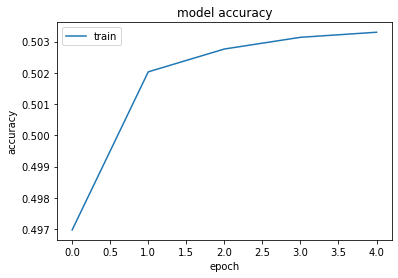

In [16]:
# summarize history for accuracy
plt.plot(hist.history['winRatio'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

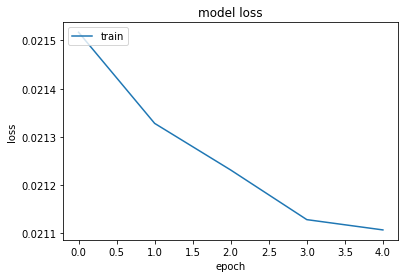

In [17]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()